# Sorting Arrays

Up to this point we have been concerned mainly with tools to access and operate on array data with NumPy.
This chapter covers algorithms related to sorting values in NumPy arrays.
These algorithms are a favorite topic in introductory computer science courses: if you've ever taken one, you probably have had dreams (or, depending on your temperament, nightmares) about *insertion sorts*, *selection sorts*, *merge sorts*, *quick sorts*, *bubble sorts*, and many, many more.
All are means of accomplishing a similar task: sorting the values in a list or array.

Python has a couple of built-in functions and methods for sorting lists and other iterable objects. The `sorted` function accepts a list and returns a sorted version of it:

In [1]:
L = [3, 1, 4, 1, 5, 9, 2, 6]
sorted(L)  # returns a sorted copy

[1, 1, 2, 3, 4, 5, 6, 9]

By contrast, the `sort` method of lists will sort the list in-place:

In [2]:
L.sort()  # acts in-place and returns None
print(L)

[1, 1, 2, 3, 4, 5, 6, 9]


Python's sorting methods are quite flexible, and can handle any iterable object. For example, here we sort a string:

In [3]:
sorted('python')

['h', 'n', 'o', 'p', 't', 'y']

These built-in sorting methods are convenient, but as previously discussed, the dynamism of Python values means they are less performant than routines designed specifically for uniform arrays of numbers.
This is where NumPy's sorting routines come in.

## Fast Sorting in NumPy: np.sort and np.argsort

The `np.sort` function is analogous to Python's built-in `sorted` function, and will efficiently return a sorted copy of an array:

In [4]:
import numpy as np

x = np.array([2, 1, 4, 3, 5])
np.sort(x)

array([1, 2, 3, 4, 5])

Similarly to the `sort` method of Python lists, you can also sort an array in-place using the array `sort` method:

In [5]:
x.sort()
print(x)

[1 2 3 4 5]


A related function is `argsort`, which instead returns the *indices* of the sorted elements:

In [6]:
x = np.array([2, 1, 4, 3, 5])
i = np.argsort(x)
print(i)

[1 0 3 2 4]


The first element of this result gives the index of the smallest element, the second value gives the index of the second smallest, and so on.
These indices can then be used (via fancy indexing) to construct the sorted array if desired:

In [7]:
x[i]

array([1, 2, 3, 4, 5])

You'll see an application of `argsort` later in this chapter.

### Sorting Along Rows or Columns

A useful feature of NumPy's sorting algorithms is the ability to sort along specific rows or columns of a multidimensional array using the `axis` argument. For example:

In [8]:
rng = np.random.default_rng(seed=42)
X = rng.integers(0, 10, (4, 6))
print(X)

[[0 7 6 4 4 8]
 [0 6 2 0 5 9]
 [7 7 7 7 5 1]
 [8 4 5 3 1 9]]


In [9]:
# sort each column of X
np.sort(X, axis=0)

array([[0, 4, 2, 0, 1, 1],
       [0, 6, 5, 3, 4, 8],
       [7, 7, 6, 4, 5, 9],
       [8, 7, 7, 7, 5, 9]], dtype=int64)

In [10]:
# sort each row of X
np.sort(X, axis=1)

array([[0, 4, 4, 6, 7, 8],
       [0, 0, 2, 5, 6, 9],
       [1, 5, 7, 7, 7, 7],
       [1, 3, 4, 5, 8, 9]], dtype=int64)

Keep in mind that this treats each row or column as an independent array, and any relationships between the row or column values will be lost!

## Partial Sorts: Partitioning

Sometimes we're not interested in sorting the entire array, but simply want to find the *k* smallest values in the array. NumPy enables this with the `np.partition` function. `np.partition` takes an array and a number *K*; the result is a new array with the smallest *K* values to the left of the partition and the remaining values to the right:

In [11]:
x = np.array([7, 2, 3, 1, 6, 5, 4])
np.partition(x, 3)

array([2, 1, 3, 4, 6, 5, 7])

Notice that the first three values in the resulting array are the three smallest in the array, and the remaining array positions contain the remaining values.
Within the two partitions, the elements have arbitrary order.

Similarly to sorting, we can partition along an arbitrary axis of a multidimensional array:

In [12]:
np.partition(X, 2, axis=1)

array([[0, 4, 4, 7, 6, 8],
       [0, 0, 2, 6, 5, 9],
       [1, 5, 7, 7, 7, 7],
       [1, 3, 4, 5, 8, 9]], dtype=int64)

The result is an array where the first two slots in each row contain the smallest values from that row, with the remaining values filling the remaining slots.

Finally, just as there is an `np.argsort` function that computes indices of the sort, there is an `np.argpartition` function that computes indices of the partition.
We'll see both of these in action in the following section.

## Example: k-Nearest Neighbors

Let's quickly see how we might use the `argsort` function along multiple axes to find the nearest neighbors of each point in a set.
We'll start by creating a random set of 10 points on a two-dimensional plane.
Using the standard convention, we'll arrange these in a $10\times 2$ array:

In [13]:
X = rng.random((10, 2))

To get an idea of how these points look, let's generate a quick scatter plot (see the following figure):

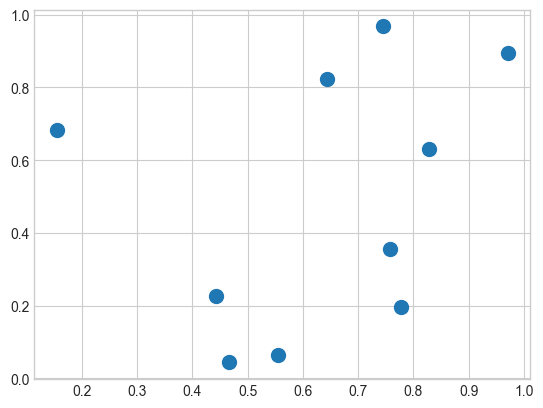

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
plt.scatter(X[:, 0], X[:, 1], s=100)

Now we'll compute the distance between each pair of points.
Recall that the squared distance between two points is the sum of the squared differences in each dimension;
using the efficient broadcasting ([Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb)) and aggregation ([Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb))  routines provided by NumPy we can compute the matrix of square distances in a single line of code:

In [15]:
dist_sq = np.sum((X[:, np.newaxis] - X[np.newaxis, :]) ** 2, axis=-1)

This operation has a lot packed into it, and it might be a bit confusing if you're unfamiliar with NumPy's broadcasting rules. When you come across code like this, it can be useful to break it down into its component steps:

In [16]:
# for each pair of points, compute differences in their coordinates
differences = X[:, np.newaxis] - X[np.newaxis, :]
differences.shape

(10, 10, 2)

In [17]:
# square the coordinate differences
sq_differences = differences ** 2
sq_differences.shape

(10, 10, 2)

In [18]:
# sum the coordinate differences to get the squared distance
dist_sq = sq_differences.sum(-1)
dist_sq.shape

(10, 10)

As a quick check of our logic, we should see that the diagonal of this matrix (i.e., the set of distances between each point and itself) is all zeros:

In [19]:
dist_sq.diagonal()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

With the pairwise square distances converted, we can now use `np.argsort` to sort along each row. The leftmost columns will then give the indices of the nearest neighbors:

In [20]:
nearest = np.argsort(dist_sq, axis=1)
print(nearest)

[[0 9 3 5 4 8 1 6 2 7]
 [1 7 2 6 4 8 3 0 9 5]
 [2 7 1 6 4 3 8 0 9 5]
 [3 0 4 5 9 6 1 2 8 7]
 [4 6 3 1 2 7 0 5 9 8]
 [5 9 3 0 4 6 8 1 2 7]
 [6 4 2 1 7 3 0 5 9 8]
 [7 2 1 6 4 3 8 0 9 5]
 [8 0 1 9 3 4 7 2 6 5]
 [9 0 5 3 4 8 6 1 2 7]]


Notice that the first column gives the numbers 0 through 9 in order: this is due to the fact that each point's closest neighbor is itself, as we would expect.

By using a full sort here, we've actually done more work than we need to in this case. If we're simply interested in the nearest $k$ neighbors, all we need to do is partition each row so that the smallest $k + 1$ squared distances come first, with larger distances filling the remaining positions of the array. We can do this with the `np.argpartition` function:

In [21]:
K = 2
nearest_partition = np.argpartition(dist_sq, K + 1, axis=1)

In order to visualize this network of neighbors, let's quickly plot the points along with lines representing the connections from each point to its two nearest neighbors (see the following figure):

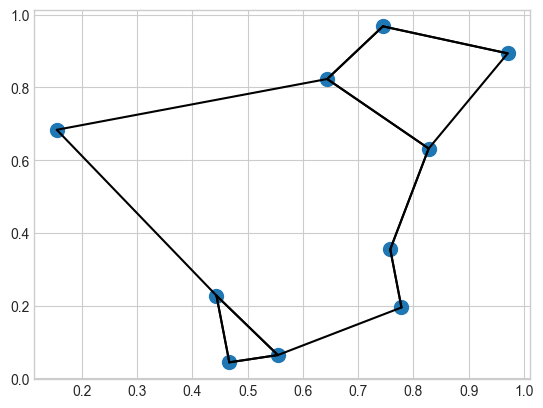

In [22]:
plt.scatter(X[:, 0], X[:, 1], s=100)

# draw lines from each point to its two nearest neighbors
K = 2

for i in range(X.shape[0]):
    for j in nearest_partition[i, :K+1]:
        # plot a line from X[i] to X[j]
        # use some zip magic to make it happen:
        plt.plot(*zip(X[j], X[i]), color='black')

Each point in the plot has lines drawn to its two nearest neighbors.
At first glance, it might seem strange that some of the points have more than two lines coming out of them: this is due to the fact that if point A is one of the two nearest neighbors of point B, this does not necessarily imply that point B is one of the two nearest neighbors of point A.

Although the broadcasting and row-wise sorting of this approach might seem less straightforward than writing a loop, it turns out to be a very efficient way of operating on this data in Python.
You might be tempted to do the same type of operation by manually looping through the data and sorting each set of neighbors individually, but this would almost certainly lead to a slower algorithm than the vectorized version we used. The beauty of this approach is that it's written in a way that's agnostic to the size of the input data: we could just as easily compute the neighbors among 100 or 1,000,000 points in any number of dimensions, and the code would look the same.

Finally, I'll note that when doing very large nearest neighbor searches, there are tree-based and/or approximate algorithms that can scale as $\mathcal{O}[N\log N]$ or better rather than the $\mathcal{O}[N^2]$ of the brute-force algorithm. One example of this is the KD-Tree, [implemented in Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html).